In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
file_path = r"C:\Users\gigan\OneDrive\Desktop\NYU\Spring 2025\Projects\IAQF\IAQF_masterfile_values.xlsx"

In [2]:
df_returns = pd.read_excel(file_path, sheet_name="Return", parse_dates=["Date"])
df_weights = pd.read_excel(file_path, sheet_name="Weights", parse_dates=["Date"])
df_beta = pd.read_excel(file_path, sheet_name="Beta", parse_dates=["Date"])

def clean_ticker_names(df):
    # Remove " UN Equity" or " UW Equity" at the end of column names using a regex pattern.
    df.columns = df.columns.str.replace(r' (UN|UW) Equity$', '', regex=True)
    # Strip any leading/trailing whitespace for safety.
    df.columns = df.columns.str.strip()
    return df

# Apply the cleaning function to all dataframes
df_returns = clean_ticker_names(df_returns)
df_weights = clean_ticker_names(df_weights)
df_beta = clean_ticker_names(df_beta)

df_returns.set_index("Date", inplace=True)
df_weights.set_index("Date", inplace=True)
df_beta.set_index("Date", inplace=True)

m7_tickers = ["NVDA", "META", "TSLA", "AMZN", "GOOGL", "MSFT", "AAPL"]

# Determine all tickers present in the Beta data
all_tickers = df_beta.columns.tolist()

# Identify the non-Magnificent 7 tickers.
other_tickers = [ticker for ticker in all_tickers if ticker not in m7_tickers]

In [3]:
# Compute the index beta on each day as the weighted average of individual betas.
# (Assumes that the weights sum to 1 for each day.)
df_index_beta = (df_weights[all_tickers] * df_beta[all_tickers]).sum(axis=1)

# Compute the contribution from the Magnificent 7.
df_m7_beta = (df_weights[m7_tickers] * df_beta[m7_tickers]).sum(axis=1)

# And the contribution from the remaining stocks.
df_others_beta = (df_weights[other_tickers] * df_beta[other_tickers]).sum(axis=1)

# Combine these into a single DataFrame for analysis.
df_analysis = pd.DataFrame({
    "Index_Beta": df_index_beta,
    "M7_Beta": df_m7_beta,
    "Others_Beta": df_others_beta,
    "M7_Ratio": df_m7_beta / df_index_beta  # Fraction of index beta driven by the Magnificent 7
})

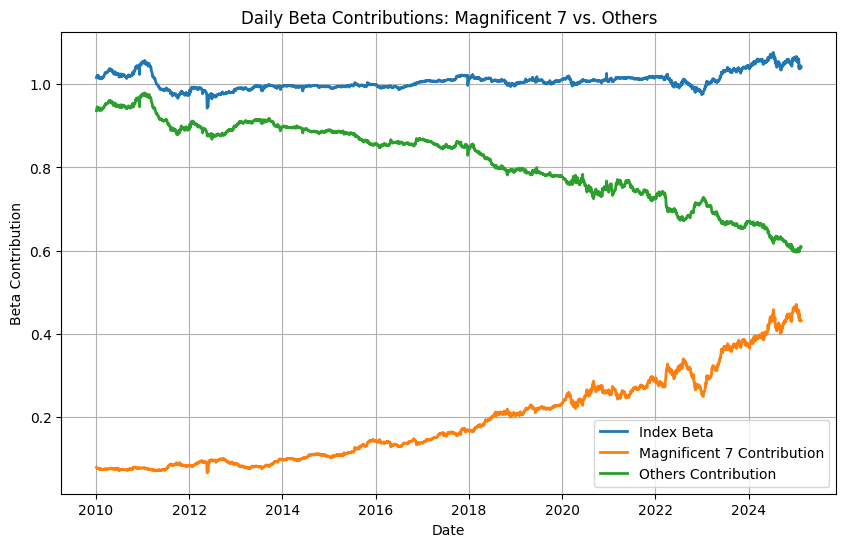

In [6]:
# Plot the beta contributions over time.
plt.figure(figsize=(10, 6))
plt.plot(df_analysis.index, df_analysis["Index_Beta"], label="Index Beta", linewidth=2)
plt.plot(df_analysis.index, df_analysis["M7_Beta"], label="Magnificent 7 Contribution", linewidth=2)
plt.plot(df_analysis.index, df_analysis["Others_Beta"], label="Others Contribution", linewidth=2)
plt.xlabel("Date")
plt.ylabel("Beta Contribution")
plt.title("Daily Beta Contributions: Magnificent 7 vs. Others")
plt.legend()
plt.grid(True)
plt.show()

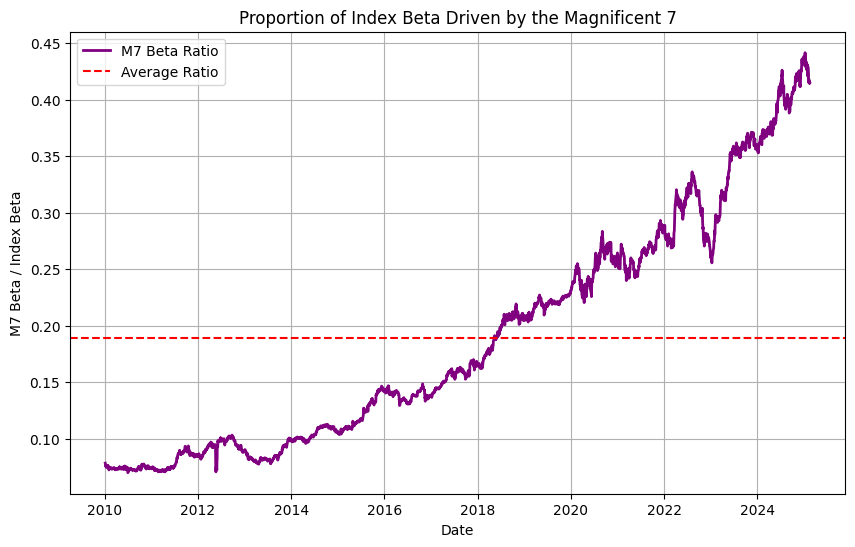

In [9]:
# Plot the ratio of the M7 contribution to the total index beta.
plt.figure(figsize=(10, 6))
plt.plot(df_analysis.index, df_analysis["M7_Ratio"], label="M7 Beta Ratio", color='purple', linewidth=2)
plt.axhline(y=df_analysis["M7_Ratio"].mean(), color='red', linestyle='--', label="Average Ratio")
plt.xlabel("Date")
plt.ylabel("M7 Beta / Index Beta")
plt.title("Proportion of Index Beta Driven by the Magnificent 7")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Summary statistics for beta contributions
beta_stats = pd.DataFrame({
    "Index_Beta": [df_analysis["Index_Beta"].mean(), df_analysis["Index_Beta"].std()],
    "M7_Beta": [df_analysis["M7_Beta"].mean(), df_analysis["M7_Beta"].std()],
    "Others_Beta": [df_analysis["Others_Beta"].mean(), df_analysis["Others_Beta"].std()]
}, index=["Mean", "Std"])
print("Beta Summary Statistics:")
print(beta_stats)

Beta Summary Statistics:
      Index_Beta   M7_Beta  Others_Beta
Mean    1.007557  0.191632     0.815925
Std     0.025921  0.106348     0.095867



Significant Tesla drop events in 2024:
Date
2024-01-25   -0.121253
2024-03-04   -0.071555
2024-04-15   -0.055949
2024-04-30   -0.055501
2024-07-11   -0.084441
2024-07-24   -0.123346
2024-08-01   -0.065541
2024-08-22   -0.056479
2024-09-06   -0.084459
2024-10-11   -0.087825
2024-11-12   -0.061457
2024-11-14   -0.057716
2024-12-18   -0.082795
Name: TSLA, dtype: float64


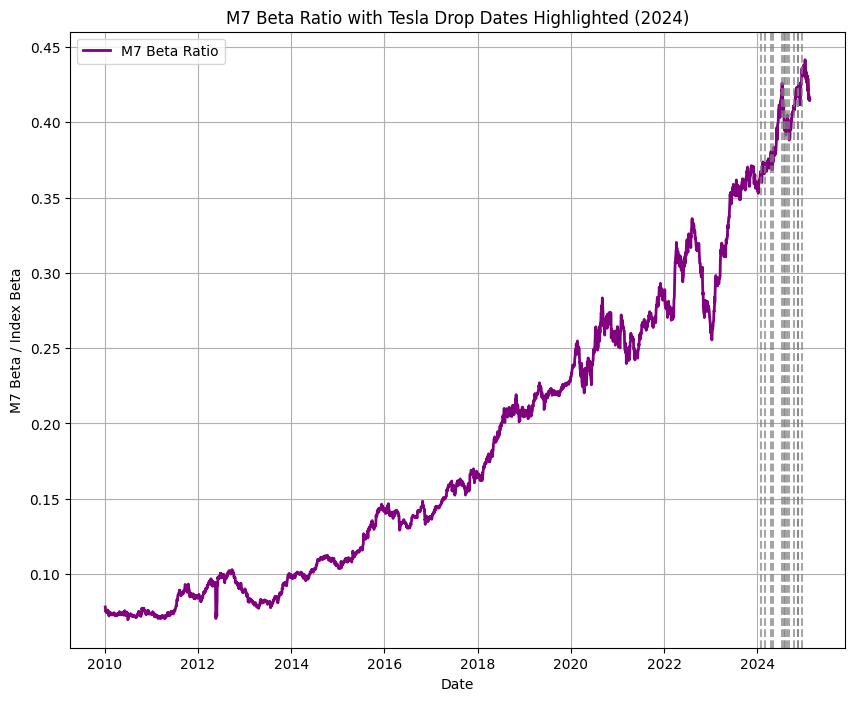

In [12]:
# A closer look at Tesla's performance in 2024:
if "TSLA" in df_returns.columns:
    tsla_returns = df_returns["TSLA"]
    # Define a threshold for a "significant" drop, e.g., daily return less than -5%.
    tsla_drop_events = tsla_returns[(tsla_returns.index.year == 2024) & (tsla_returns < -0.05)]
    print("\nSignificant Tesla drop events in 2024:")
    print(tsla_drop_events)

    # Optionally, highlight these dates on the M7 beta ratio plot.
    plt.figure(figsize=(10, 8))
    plt.plot(df_analysis.index, df_analysis["M7_Ratio"], label="M7 Beta Ratio", color='purple', linewidth=2)
    for drop_date in tsla_drop_events.index:
        plt.axvline(x=drop_date, color='gray', linestyle='--', alpha=0.7)
    plt.xlabel("Date")
    plt.ylabel("M7 Beta / Index Beta")
    plt.title("M7 Beta Ratio with Tesla Drop Dates Highlighted (2024)")
    plt.legend()
    plt.grid(True)
    plt.show()

Correlation between rolling 180-day average correlation and Mag7 cumulative returns: 0.31390293302054584


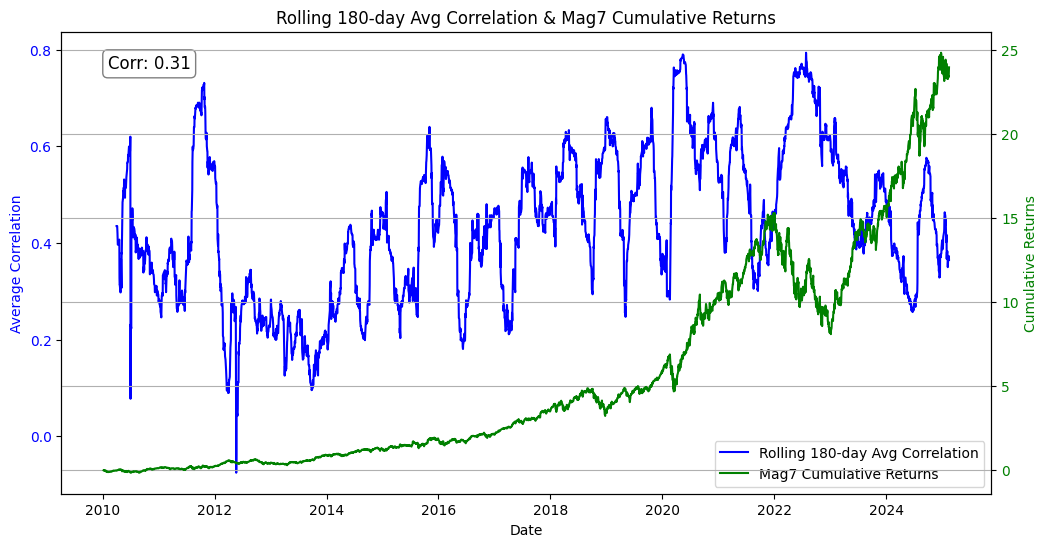

In [20]:
# %% [code]
# Set rolling window to 180 days
rolling_window = 60

# Extract Mag7 returns (using the cleaned DataFrame and m7_tickers list)
df_mag7 = df_returns[m7_tickers]

# Compute the rolling average pairwise correlation for the Mag7
import numpy as np
avg_corr = []
dates = []

for i in range(rolling_window - 1, len(df_mag7)):
    window_data = df_mag7.iloc[i - rolling_window + 1: i + 1]
    corr_matrix = window_data.corr()
    # Get the unique pairwise correlations (upper triangle without the diagonal)
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    avg_pairwise_corr = upper_triangle.stack().mean()
    avg_corr.append(avg_pairwise_corr)
    dates.append(df_mag7.index[i])

# Create a Series for the rolling average correlation
df_avg_corr = pd.Series(avg_corr, index=dates, name="Avg_M7_Correlation")

# %% [code]
# Compute the Mag7 weighted average daily returns
df_mag7_weighted_return = (df_returns[m7_tickers] * df_weights[m7_tickers]).sum(axis=1) / df_weights[m7_tickers].sum(axis=1)

# Compute the cumulative return from the daily weighted returns
df_mag7_cum_return = (1 + df_mag7_weighted_return).cumprod() - 1

# %% [code]
# Compute the correlation between cumulative return and rolling average correlation
# Align the two series on their common dates
common_idx = df_avg_corr.index.intersection(df_mag7_cum_return.index)
corr_value = df_avg_corr.loc[common_idx].corr(df_mag7_cum_return.loc[common_idx])
print("Correlation between rolling 180-day average correlation and Mag7 cumulative returns:", corr_value)

# %% [code]
# Plot both the rolling average correlation and the cumulative returns on the same plot
fig, ax1 = plt.subplots(figsize=(12,6))

# Plot the rolling 180-day average correlation on the primary y-axis
line1, = ax1.plot(df_avg_corr.index, df_avg_corr, color='blue', label='Rolling 180-day Avg Correlation')
ax1.set_xlabel("Date")
ax1.set_ylabel("Average Correlation", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Annotate the computed correlation on the plot
ax1.text(0.05, 0.95, f'Corr: {corr_value:.2f}', transform=ax1.transAxes, fontsize=12,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

# Create a secondary y-axis for the cumulative returns
ax2 = ax1.twinx()
line2, = ax2.plot(df_mag7_cum_return.index, df_mag7_cum_return, color='green', label='Mag7 Cumulative Returns')
ax2.set_ylabel("Cumulative Returns", color='green')
ax2.tick_params(axis='y', labelcolor='green')

# Combine the legends from both plots
lines = [line1, line2]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='best')

plt.title("Rolling 180-day Avg Correlation & Mag7 Cumulative Returns")
plt.grid(True)
plt.show()

TSLA significant drop date in 2024: 2024-07-24 00:00:00


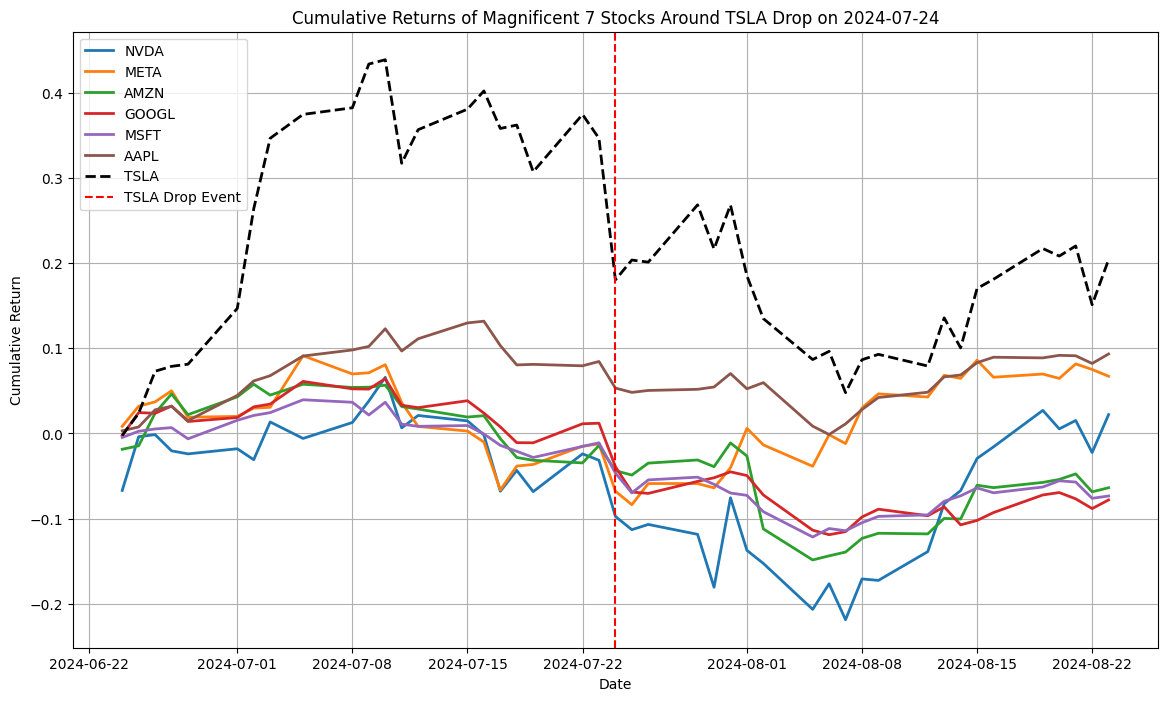

In [33]:
# %% [code]
import pandas as pd
import matplotlib.pyplot as plt

# Identify TSLA drop events in 2024 with daily return below -5%
tsla_drop_events = df_returns["TSLA"][(df_returns.index.year == 2024) & (df_returns["TSLA"] < -0.05)]

# If there are multiple events, select the most severe drop (lowest return)
if not tsla_drop_events.empty:
    tsla_drop_date = tsla_drop_events.idxmin()  # date with the most negative return
    print("TSLA significant drop date in 2024:", tsla_drop_date)
else:
    raise ValueError("No TSLA drop events meeting the threshold found in 2024.")

# Define a window around the drop event: e.g., 30 days before and 30 days after
window_start = tsla_drop_date - pd.Timedelta(days=30)
window_end   = tsla_drop_date + pd.Timedelta(days=30)

# Determine the other Magnificent 7 stocks (excluding TSLA)
other_mag7 = [ticker for ticker in m7_tickers if ticker != "TSLA"]

# Extract returns for the window, including TSLA for reference
window_returns = df_returns.loc[window_start:window_end, other_mag7 + ["TSLA"]]

# Calculate cumulative returns: (1 + daily return).cumprod() - 1
cumulative_window_returns = (1 + window_returns).cumprod() - 1

# %% [code]
# Plot cumulative returns in the defined window
plt.figure(figsize=(14, 8))

# Plot the other Mag7 stocks
for ticker in other_mag7:
    plt.plot(cumulative_window_returns.index, cumulative_window_returns[ticker], label=ticker, linewidth=2)

# Plot TSLA with a distinct style to highlight the drop event
plt.plot(cumulative_window_returns.index, cumulative_window_returns["TSLA"],
         label="TSLA", color="black", linewidth=2, linestyle="--")

# Mark the TSLA drop event date with a vertical red dashed line
plt.axvline(tsla_drop_date, color='red', linestyle='--', label="TSLA Drop Event")

plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.title(f"Cumulative Returns of Magnificent 7 Stocks Around TSLA Drop on {tsla_drop_date.date()}")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Before 2017:
  Average return on TSLA drop days (other Mag7 stocks): -0.0095
  Average return on TSLA rise days (other Mag7 stocks): 0.0079

After 2017:
  Average return on TSLA drop days (other Mag7 stocks): -0.0137
  Average return on TSLA rise days (other Mag7 stocks): 0.0128


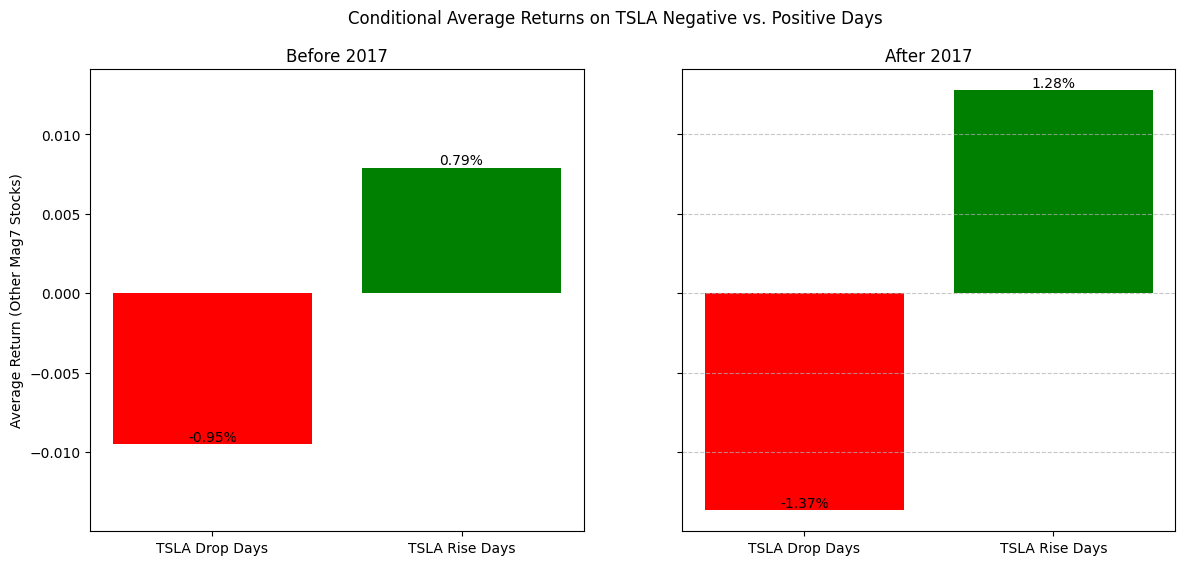

In [ ]:
# Define thresholds for TSLA events
neg_threshold = -0.03  # TSLA drops by 3% or more
pos_threshold =  0.03  # TSLA rises by 3% or more

# Split the data into two periods: before 2017 and from 2017 onwards
df_pre2017 = df_returns.loc[df_returns.index < '2017-01-01']
df_post2017 = df_returns.loc[df_returns.index >= '2017-01-01']

# Identify TSLA drop and rise days for each period
tsla_drop_days_pre  = df_pre2017["TSLA"][df_pre2017["TSLA"] <= neg_threshold].index
tsla_rise_days_pre  = df_pre2017["TSLA"][df_pre2017["TSLA"] >= pos_threshold].index

tsla_drop_days_post = df_post2017["TSLA"][df_post2017["TSLA"] <= neg_threshold].index
tsla_rise_days_post = df_post2017["TSLA"][df_post2017["TSLA"] >= pos_threshold].index

# Identify the other Magnificent 7 stocks (excluding TSLA)
other_mag7 = [ticker for ticker in m7_tickers if ticker != "TSLA"]

# Compute the average daily return for other Mag7 stocks on TSLA drop and rise days in each period
avg_return_drop_pre = df_pre2017.loc[tsla_drop_days_pre, other_mag7].mean(axis=1).mean()
avg_return_rise_pre = df_pre2017.loc[tsla_rise_days_pre, other_mag7].mean(axis=1).mean()

avg_return_drop_post = df_post2017.loc[tsla_drop_days_post, other_mag7].mean(axis=1).mean()
avg_return_rise_post = df_post2017.loc[tsla_rise_days_post, other_mag7].mean(axis=1).mean()

print("Before 2017:")
print("  Average return on TSLA drop days (other Mag7 stocks):", round(avg_return_drop_pre, 4))
print("  Average return on TSLA rise days (other Mag7 stocks):", round(avg_return_rise_pre, 4))

print("\nAfter 2017:")
print("  Average return on TSLA drop days (other Mag7 stocks):", round(avg_return_drop_post, 4))
print("  Average return on TSLA rise days (other Mag7 stocks):", round(avg_return_rise_post, 4))

# Plot the results using bar charts for each period
categories = ['TSLA Drop Days', 'TSLA Rise Days']
values_pre  = [avg_return_drop_pre, avg_return_rise_pre]
values_post = [avg_return_drop_post, avg_return_rise_post]

fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Plot for the period before 2017
axs[0].bar(categories, values_pre, color=['red','green'])
axs[0].set_title('Before 2017')
axs[0].set_ylabel('Average Return (Other Mag7 Stocks)')
for i, v in enumerate(values_pre):
    axs[0].text(i, v, f"{v:.2%}", ha='center', va='bottom')

# Plot for the period from 2017 onwards
axs[1].bar(categories, values_post, color=['red','green'])
axs[1].set_title('After 2017')
for i, v in enumerate(values_post):
    axs[1].text(i, v, f"{v:.2%}", ha='center', va='bottom')

plt.suptitle('Conditional Average Returns on TSLA Negative vs. Positive Days')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()